In [ ]:
# This makes a simple cube of FITS files, so as to inspect images en masse with DS9
# ... or makes a median of them

# created 2017 Nov 19 by E.S.

In [18]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import pandas as pd
import datetime
from astropy.io import fits
import asciitable
from pathlib import Path
import glob
import scipy
import os
from scipy.ndimage import gaussian_filter
from astropy.convolution import convolve, Gaussian1DKernel, interpolate_replace_nans
from lmircam_tools import process_readout

In [12]:
# set file paths and datasets

dirTreeStem = ('./asterism/processedData/raw_data/')
png_stem = ('/Volumes/seagate_external_drive/lbti_data_reduction/'
               '181224_trapezium/pngs/')
medians_stem = ('/Volumes/seagate_external_drive/lbti_data_reduction/'
               '181224_trapezium/medians/')

In [13]:
trapezium_files = glob.glob(dirTreeStem + "*fits")

In [14]:
trapezium_files

['./asterism/processedData/raw_data/SX_half_moondither_10.fits',
 './asterism/processedData/raw_data/DX_half_moondither_14.fits',
 './asterism/processedData/raw_data/DX_half_moondither_02.fits',
 './asterism/processedData/raw_data/SX_half_moondither_06.fits',
 './asterism/processedData/raw_data/SX_half_moondither_07.fits',
 './asterism/processedData/raw_data/DX_half_moondither_03.fits',
 './asterism/processedData/raw_data/DX_half_moondither_15.fits',
 './asterism/processedData/raw_data/SX_half_moondither_11.fits',
 './asterism/processedData/raw_data/DX_half_moondither_08.fits',
 './asterism/processedData/raw_data/SX_half_moondither_16.fits',
 './asterism/processedData/raw_data/DX_half_moondither_12.fits',
 './asterism/processedData/raw_data/DX_half_moondither_04.fits',
 './asterism/processedData/raw_data/SX_half_moondither_01.fits',
 './asterism/processedData/raw_data/DX_half_moondither_05.fits',
 './asterism/processedData/raw_data/DX_half_moondither_13.fits',
 './asterism/processedDat

In [72]:
def make_pngs(file_list):
    '''
    Make a bunch of PNGs, to make inspection easier
    '''
    for t in file_list:
        
        print(t)
        
        img, header = fits.getdata(t,0,header=True)
        
        if (t == file_list[0]):
            dark2d = np.copy(img[1])
        
        '''
        print(np.shape(np.tile(np.median(img[1], axis = 0), reps=2048)))
        plt.imshow(np.tile(np.median(img[1], axis = 0), reps=2048))
        plt.show()
        # dark vector 
        dark1d = np.median(img[1], axis = 0)
        dark2d = np.tile(dark1d,2048)
        #dark2d = np.repeat(dark1d.flatten(), np.shape(img[1]), axis = 0)
        '''
        
        # subtract ersatz dark
        sci_img = np.subtract(img[1], dark2d)
        
        sci_img = gaussian_filter(sci_img, sigma=5)
        
        plt.clf()
        plt.imshow(sci_img, origin="lower")
        plt.colorbar()
        plt.savefig(png_stem + os.path.basename(t).split(".")[0] + ".png", overwrite=True)
        plt.clf()

In [83]:
trapezium_files[159]

'/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/raw_data/lm_181224_001262.fits'

In [84]:
make_pngs(trapezium_files[159:])

/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/raw_data/lm_181224_001262.fits
/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/raw_data/lm_181224_001263.fits
/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/raw_data/lm_181224_001264.fits
/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/raw_data/lm_181224_001265.fits
/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/raw_data/lm_181224_001266.fits
/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/raw_data/lm_181224_001267.fits
/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/raw_data/lm_181224_001268.fits
/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/raw_data/lm_181224_001269.fits
/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/raw_data/lm_181224_001270.fits
/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/raw_data/lm_181224_001271.fits


<Figure size 432x288 with 0 Axes>

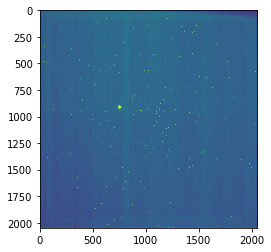

In [7]:
plt.imshow(ersatz_dark[1])
plt.show()

In [117]:
def make_median(file_write_string,file_read_string,ditherPos,startNum,stopNum,xSize=2048,ySize=2048,N=1):
    '''
    makes a median from a range of FITS files
    INPUTS--
    ditherPos: number indicating the dither number
    startNum: first frame number
    stopNum: last frame number (inclusive)
    xSize: pixels in x-dimension
    ySize: pixels in y-dimension
    N: number of frames between each one used to make the median (default is 1: no skipped frames)
    '''
    N = N # use every N frames
    xSize = xSize
    ySize = ySize
    sliceNum = 0 # initialize cube slice number
    cubeArray = np.zeros((int(np.divide(stopNum-startNum+1,N)),xSize,ySize),dtype=np.int64)
    for f in range(startNum,stopNum+1): # loop over filenames
        if (f%N == 0): 
            #print('----------------------------------------')
            #print(str(f))
            image, header = fits.getdata(dirTreeStem+
                                         file_read_string+
                                         str("{:0>6d}".format(f))+
                                         '.fits',
                                         0,
                                         header=True)
            
            cubeArray[sliceNum,:,:] = image[1]
            sliceNum += 1 # move to next slice
    
    # take median
    medianArray = np.median(cubeArray,axis=0)
    
    # save median
    fits.writeto(medians_stem+file_write_string+'dither_'+str("{:0>2d}".format(ditherPos))+'.fits', 
                 data = medianArray,
                 header = header,
                 overwrite=True)

In [118]:
# run the function

make_median("SX_half_moon","lm_181224_",1,1103,1111)
make_median("SX_half_moon","lm_181224_",2,1113,1121)
make_median("SX_half_moon","lm_181224_",3,1123,1131)
make_median("SX_half_moon","lm_181224_",4,1133,1141)
make_median("SX_half_moon","lm_181224_",5,1143,1151)
make_median("SX_half_moon","lm_181224_",6,1153,1161)
make_median("SX_half_moon","lm_181224_",7,1163,1171)
make_median("SX_half_moon","lm_181224_",8,1173,1181)
make_median("SX_half_moon","lm_181224_",9,1183,1191)
make_median("SX_half_moon","lm_181224_",10,1193,1201)
make_median("SX_half_moon","lm_181224_",11,1203,1211)
make_median("SX_half_moon","lm_181224_",12,1213,1221)
make_median("SX_half_moon","lm_181224_",13,1223,1231)
make_median("SX_half_moon","lm_181224_",14,1233,1241)
make_median("SX_half_moon","lm_181224_",15,1243,1251)
make_median("SX_half_moon","lm_181224_",16,1253,1261)

In [119]:
# run the function

make_median("DX_half_moon","lm_181224_",1,1263,1271)
make_median("DX_half_moon","lm_181224_",2,1273,1281)
make_median("DX_half_moon","lm_181224_",3,1283,1291)
make_median("DX_half_moon","lm_181224_",4,1293,1301)
make_median("DX_half_moon","lm_181224_",5,1303,1311)
make_median("DX_half_moon","lm_181224_",6,1313,1321)
make_median("DX_half_moon","lm_181224_",7,1323,1331)
make_median("DX_half_moon","lm_181224_",8,1333,1341)
make_median("DX_half_moon","lm_181224_",9,1343,1351)
make_median("DX_half_moon","lm_181224_",10,1353,1361)
make_median("DX_half_moon","lm_181224_",11,1363,1371)
make_median("DX_half_moon","lm_181224_",12,1373,1381)
make_median("DX_half_moon","lm_181224_",13,1383,1391)
make_median("DX_half_moon","lm_181224_",14,1393,1401)
make_median("DX_half_moon","lm_181224_",15,1403,1411)
make_median("DX_half_moon","lm_181224_",16,1413,1421)

In [108]:
make_median(file_write_string = "DX_pinholes_",
            file_read_string = "lm_190125_",
            ditherPos = 1,
            startNum = 33,
            stopNum = 42)

In [110]:
make_median(file_write_string = "dark_for_DX_pinholes_",
            file_read_string = "lm_190125_",
            ditherPos = 1,
            startNum = 43,
            stopNum = 52)

In [109]:
make_median(file_write_string = "SX_pinholes_",
            file_read_string = "lm_190125_",
            ditherPos = 1,
            startNum = 53,
            stopNum = 62)

In [111]:
make_median(file_write_string = "dark_for_SX_pinholes_",
            file_read_string = "lm_190125_",
            ditherPos = 1,
            startNum = 63,
            stopNum = 72)

In [3]:
trapezium_stem = ('/Volumes/seagate_external_drive/lbti_data_reduction/181224_trapezium/')
pinholes_stem = ('/Volumes/seagate_external_drive/lbti_data_reduction/190125_pinhole_grid/')

In [9]:
# dark-subtract

dx_pinholes_pre_dark_subt, header = fits.getdata(pinholes_stem + "medians/DX_pinholes_dither_01.fits",0,header=True)
dark_dx_pinholes, header = fits.getdata(pinholes_stem + "medians/dark_for_DX_pinholes_dither_01.fits",0,header=True)

sx_pinholes_pre_dark_subt, header = fits.getdata(pinholes_stem + "medians/SX_pinholes_dither_01.fits",0,header=True)
dark_sx_pinholes, header = fits.getdata(pinholes_stem + "medians/dark_for_SX_pinholes_dither_01.fits",0,header=True)

dx_pinholes_post_dark_subt = np.subtract(dx_pinholes_pre_dark_subt,dark_dx_pinholes)
sx_pinholes_post_dark_subt = np.subtract(sx_pinholes_pre_dark_subt,dark_sx_pinholes)



# fix bad pixels

# define the convolution kernel (normalized by default)
kernel1 = np.ones((3,3)) # just a patch around the pixel

# read in old bad pixel mask
badpix = fits.getdata("bpm_2048x2048_2017B.fits")
# turn 1->nan (bad), 0->1 (good) for interpolate_replace_nans
ersatz = np.nan*np.ones(np.shape(badpix))
ersatz[badpix == 0] = 1.
badpix = ersatz # rename
del ersatz

# multiply science frames by badpix mask
dx_pinholes_post_dark_subt_badnan = np.multiply(dx_pinholes_post_dark_subt,badpix)
sx_pinholes_post_dark_subt_badnan = np.multiply(sx_pinholes_post_dark_subt,badpix)

# convolve
dx_pinholes_post_dark_subt_fixpixed = interpolate_replace_nans(array=dx_pinholes_post_dark_subt_badnan, 
                                                               kernel=kernel1).astype(np.int32)
sx_pinholes_post_dark_subt_fixpixed = interpolate_replace_nans(array=sx_pinholes_post_dark_subt_badnan, 
                                                               kernel=kernel1).astype(np.int32)
      
# write
fits.writeto(pinholes_stem + "final_images/dx_pinholes_190125.fits", 
                 data = dx_pinholes_post_dark_subt_fixpixed,
                 header = header,
                 overwrite=True)
fits.writeto(pinholes_stem + "final_images/sx_pinholes_190125.fits", 
                 data = sx_pinholes_post_dark_subt_fixpixed,
                 header = header,
                 overwrite=True)

In [19]:
# define the convolution kernel (normalized by default)
kernel1 = np.ones((3,3)) # just a patch around the pixel

# read in old bad pixel mask
badpix = fits.getdata("bpm_2048x2048_2017B.fits")
# turn 1->nan (bad), 0->1 (good) for interpolate_replace_nans
ersatz = np.nan*np.ones(np.shape(badpix))
ersatz[badpix == 0] = 1.
badpix = ersatz # rename
del ersatz

for t in range(0,len(trapezium_files)):
    
    sci_img, header = fits.getdata(trapezium_files[t],0,header=True)
    
    # ersatz dark subtraction
    sci_img_backsubt = process_readout.bkgdsub(sci_img, "median")
    
    # multiply science frames by badpix mask
    sci_img_backsubt_badnan = np.multiply(sci_img_backsubt,badpix)
    
    # bad pixel fixing
    sci_img_backsubt_fixpixed = interpolate_replace_nans(array=sci_img_backsubt_badnan, 
                                                               kernel=kernel1).astype(np.int32)
    
    # smooth a bit
    sci_img_backsubt_fixpixed_smoothed = scipy.ndimage.filters.gaussian_filter(sci_img_backsubt_fixpixed, sigma=2)
    
    # write back out
    fits.writeto(dirTreeStem + "../step01_darkSubtBadPixCorrect/" + \
                 os.path.basename(trapezium_files[t]), 
                 data = sci_img_backsubt_fixpixed_smoothed,
                 header = header,
                 overwrite=True)